In [ ]:
import pandas as pd
df = pd.read_json('data/IMDB_reviews.json')

In [ ]:
import random

# The data to load
f = "data/train.csv"

# Count the lines
num_lines = 100000#sum(1 for l in open(f))

# Sample size - in this case ~10%
size = int(num_lines / 10)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
df = pd.read_csv('data/train.csv',nrows=100000,skiprows=skip_idx)

In [ ]:
df.shape

(10000, 4)

In [ ]:
df.columns

Index(['movie_id', 'sentence1', 'sentence2', 'label'], dtype='object')

In [ ]:
df = df.sort_values(by='movie_id')

In [ ]:
df.head()

,movie_id,sentence1,sentence2,label
4842,tt0012349,"The opening title reads: ""A comedy with a smil...",Not a big fan of silent movies... ...but I was...,False
4628,tt0012349,"The opening title reads: ""A comedy with a smil...",Old but still refreshing. People of our genera...,False
6830,tt0012349,"The opening title reads: ""A comedy with a smil...",A classic in every sense of the word There are...,False
6835,tt0012349,"The opening title reads: ""A comedy with a smil...",One of the greatest films of all-time The Kid ...,True
3243,tt0012349,"The opening title reads: ""A comedy with a smil...",A comedy classic Charlie Chaplin's 1921 master...,True


In [ ]:
df1 = pd.DataFrame(columns=df.columns)

for i in set(df['movie_id']):
  # print(i)
  # print(df.loc[df['movie_id'] == i])
  df1 = df1.append(df.loc[df['movie_id'] == i].iloc[0:10])
  # x = df.loc[df['movie_id'] == i].iloc[0:10]
  # print('x',x.head())
  # break
# df1.append(x)
# print(df1)
# print(type(x))


In [ ]:
df1['movie_id'].unique().shape
df1.to_csv('data/movie_reviews.csv')

In [ ]:

!pwd

/content/drive/My Drive/Spoiler detection/spoiler-detector


In [ ]:
df1

,movie_id,sentence1,sentence2,label
346,tt0125664,"At the beginning, Kaufman's foreign man comes ...",Controversial... but I loved it! This is a fil...,False
229,tt0118880,"Cameron Poe (Nicholas Cage), a honorably disch...","""Con Air"" - What a wild ride! I have to say th...",False
111,tt0357413,"In the mid 1970's, Ron Burgundy (Will Ferrell)...",best comedy i have seen in years Two summers a...,False
271,tt0129167,"In 1957, a large alien robot crashes from orbi...",A Masterpiece... There's a moment in the Iron ...,False
33,tt1182345,The film begins with a commercial from Lunar I...,Ohh.... The concept smooth simple.... Acting d...,True
...,...,...,...,...
710,tt0078788,The story opens in Saigon late in 1969. U.S. A...,Gives to cinema what Shakespeare gave to the s...,False
713,tt0120738,"In the year 2058, Earth will soon be uninhabit...",Possibly The Worst Movie EVER! I am a huge fan...,False
79,tt0120738,"In the year 2058, Earth will soon be uninhabit...",Made(poorly) for kids With a pseudo-infant CGI...,False
447,tt0110729,This film is about a Maori family living in Au...,brilliant exposure of domestic violence the au...,False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Spoiler\ detection/spoiler-detector


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Spoiler detection/spoiler-detector'
/content/drive/MyDrive/Spoiler detection/spoiler-detector


In [ ]:
!pwd

/content/drive/MyDrive/Spoiler detection/spoiler-detector


In [ ]:
!pip install mxnet-cu110
# !pip install mxnet
!pip install gluonnlp

     |████████████████████████████████| 323.5 MB 403 bytes/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 4.2 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595744 sha256=90e55050201d9b06a3e58434ed373660cc9480afed167bb5aafd491db016d378
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


## Enhanced Sequence Inference Model
(https://arxiv.org/abs/1609.06038).


### Import Related Packages

Implementation referred from https://github.com/zhiming-xu/spoiler-detector

In [ ]:
import os
import json
import zipfile
import time
import itertools

import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import gluon, nd, init
from mxnet.gluon import nn, rnn
from mxnet import autograd, gluon, nd

import pandas as pd

# sklearn's metric function to evaluate the results of the experiment
from sklearn.metrics import accuracy_score, f1_score

# fixed random number seed
np.random.seed(9102)
mx.random.seed(9102)
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

## Data pipeline

### Load Dataset

See [dataloader](data_loader.ipynb) for how the training samples are obtained.

In [ ]:
data_folder = 'data/'
file_name = 'train.csv'
file_path = data_folder + file_name
# dev: True - only use a small dataset
# create_vocab: True - create a new vocabulary from training data
dev = True
# load train file
if dev:
    # load only n rows
    nrows = 5000
    data = pd.read_csv(file_path, nrows=nrows)
else:
    # load as many as possible
    data = pd.read_csv(file_path)
data.shape

(5000, 4)

In [ ]:
data.dropna(inplace=True)
data.shape, data.head()

((5000, 4),     movie_id  ...  label
 0  tt2802144  ...  False
 1  tt2094766  ...   True
 2  tt0335345  ...  False
 3  tt0120611  ...  False
 4  tt0086190  ...   True
 
 [5 rows x 4 columns])

In [ ]:
label2num = {'contradiction':0, 'neutral':1, 'entailment':2} #1 not spoiler

In [ ]:
# create a list of review a label paris.
dataset = [[left, right, label] for left, right, label in \
           zip(data['sentence1'], data['sentence2'], data['label']) if label!='-' ]
# randomly divide one percent from the training set as a verification set.
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset, valid_ratio=.1)
len(train_dataset), len(valid_dataset)

(4500, 500)

In [ ]:
# train_dataset[100]

In [ ]:
# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')
length_review = 300
length_plot = 600

from src.util import mp_tokenizer

tokenizer = mp_tokenizer(tokenizer, length_review, length_plot)

# Preprocess the dataset
train_dataset_token, train_data_lengths = tokenizer.process_dataset(train_dataset)
valid_dataset_token, valid_data_lengths = tokenizer.process_dataset(valid_dataset)

Done! Sequence clipping and get length Time=88.38s, #Sentences=4500
Done! Sequence clipping and get length Time=34.46s, #Sentences=500


In [ ]:
from src.util import mp_indexer
embedding = 'glove.42B.300d'
indexer = mp_indexer(train_dataset_token, embedding)
train_dataset = indexer.process_dataset(train_dataset_token)
valid_dataset = indexer.process_dataset(valid_dataset_token)

In [ ]:
import pickle

# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('train_dataset.pickle', 'wb') as handle:
#     pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open('valid_dataset.pickle', 'wb') as handle:
#     pickle.dump(valid_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('train_data_lengths.pickle', 'wb') as handle:
#     pickle.dump(train_data_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('valid_data_lengths.pickle', 'wb') as handle:
#     pickle.dump(valid_data_lengths, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('indexer.pickle', 'wb') as handle:
#     pickle.dump(indexer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
# with open('train_dataset.pickle', 'rb') as handle:
#     train_dataset = pickle.load(handle)
# with open('valid_dataset.pickle', 'rb') as handle:
#     valid_dataset = pickle.load(handle)
# with open('train_data_lengths.pickle', 'rb') as handle:
#     train_data_lengths = pickle.load(handle)
# with open('valid_data_lengths.pickle', 'rb') as handle:
#     valid_data_lengths = pickle.load(handle)
# with open('indexer.pickle', 'rb') as handle:
#     indexer = pickle.load(handle)



# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')
length_review = 300
length_plot = 600

from src.util import mp_tokenizer

tokenizer = mp_tokenizer(tokenizer, length_review, length_plot)

# Preprocess the dataset
train_dataset_token, train_data_lengths = tokenizer.process_dataset(train_dataset)
valid_dataset_token, valid_data_lengths = tokenizer.process_dataset(valid_dataset)

In [ ]:
len(train_dataset)

### Bucketing and DataLoader


In [ ]:
batch_size = 32
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():
    # Construct the DataLoader pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(nlp.data.batchify.Pad(axis=0), \
                                          nlp.data.batchify.Pad(axis=0),
                                          nlp.data.batchify.Stack())

    # n this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # train_dataloader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # valid_dataloader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

/usr/local/lib/python3.7/dist-packages/gluonnlp/data/batchify/batchify.py:235: UserWarning: Padding value is not given and will be set automatically to 0 in data.batchify.Pad(). Please check whether this is intended (e.g. value of padding index in the vocabulary).
  'Padding value is not given and will be set automatically to 0 '


FixedBucketSampler:
  sample_num=4500, batch_num=144
  key=[57, 84, 111, 138, 165, 192, 219, 246, 273, 300]
  cnt=[26, 75, 52, 68, 35, 37, 61, 15, 10, 4121]
  batch_size=[84, 57, 43, 34, 32, 32, 32, 32, 32, 32]


### Weighted softmax cross entropy loss
For a regular cross entropy loss, it is calculated by $-\vec{y}^\mathsf{T}\log \hat{\vec{y}}$. Since $\vec{y}$ is actually one-hot, so the value is $-\log\hat{y}_i$ where $i$ is the true label's index. To apply weight on this label, we multiply it with some weight value $w_i$, therefore, the loss of class $i$ is $-w_i\log\hat{y}_i$.

In [ ]:
# mx.Context(mx.gpu(0))
class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)
        
        return loss

In [ ]:
class AlignAttention(nn.Block):
    def __init__(self, **kwargs):
        super(AlignAttention, self).__init__(**kwargs)
    
    def forward(self, inp_left, inp_right):
        # input dimension is of (batch_size, seq_len, embed_size)
        # att dimension is of (batch_size, seq_len_left, seq_len_right)
        att = nd.batch_dot(inp_left, nd.transpose(inp_right, axes = (0, 2, 1)))
        # inp_left_dot dimention is of (batch_size, seq_left, embed_size)
        inp_left_dot = nd.batch_dot(nd.softmax(att, axis=-1), inp_right)
        # inp_right_dot dimension is of (batch_size, seq_right, embed_size)
        inp_right_dot = nd.batch_dot(nd.softmax(nd.transpose(att, axes=(0, 2, 1)), axis=-1), inp_left)
        # concat original (lstm output, dot multiplier, substraction, elementwise product)
        # therefore, the real size is (batch_size, seq_len_left/right, embed_size*4)
        aug_left = nd.concat(inp_left, inp_left_dot, inp_left-inp_left_dot, inp_left*inp_left_dot, dim=-1)
        aug_right = nd.concat(inp_right, inp_right_dot, inp_right-inp_right_dot, inp_right*inp_right_dot, dim=-1)
        return aug_left, aug_right, att

In [ ]:
class EnhancedSeqInfer(nn.Block):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, nfc, nclass, drop_prob, **kwargs):
        super(EnhancedSeqInfer, self).__init__(**kwargs)
        with self.name_scope():
            # dropout prob
            self.drop_prob = drop_prob
            # word embedding
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            # first lstm, from sentence embed to hidden outputs
            self.bilstm1 = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            # second lstm, from augmented embed to m
            self.bilstm2 = rnn.LSTM(nhidden, num_layers=1, dropout=drop_prob, bidirectional=True)
            # enhancement
            self.align_att = AlignAttention()
            # this layer is used to output the final class
            self.output_layer = nn.HybridSequential()
            self.output_layer.add(nn.Dense(nfc, activation='tanh'), nn.Dropout(rate=drop_prob), \
                                  nn.Dense(nfc, activation='tanh'), nn.Dropout(rate=drop_prob), \
                                  nn.Dense(nclass))

    def forward(self, inp_left, inp_right):
        # inp is a list containing left_text and right_text
        # their size: [batch, token_idx]
        # inp_embed_left/right size: [batch, seq_len, embed_size]
        inp_embed_left = self.embedding_layer(inp_left)
        inp_embed_right = self.embedding_layer(inp_right)
        # rnn requires the first dimension to be the time steps, output is (seq_len, batch_size, embed_size)
        h_output_left = self.bilstm1(nd.transpose(inp_embed_left, axes=(1, 0, 2)))
        h_output_right = self.bilstm1(nd.transpose(inp_embed_right, axes=(1, 0, 2)))
        m_left, m_right, att = self.align_att(nd.transpose(h_output_left, axes=(1, 0, 2)), \
                                                      nd.transpose(h_output_right, axes=(1, 0, 2)))
        # apply another layer of lstm
        # v_left/right shape is (seq_len, batch_size, embed_size)
        v_left = self.bilstm2(nd.transpose(m_left, axes=(1, 0, 2)))
        v_right = self.bilstm2(nd.transpose(m_right, axes=(1, 0, 2)))
        # restore v's shape (batch_size, seq_len, embed_size)
        v_left = nd.transpose(v_left, axes=(1, 0, 2))
        v_right = nd.transpose(v_right, axes=(1, 0, 2))
        # apply max pooling 1D and avg pooling 1D
        v_left_avg = nd.sum(v_left, axis=1) / v_left.shape[1]
        v_right_avg = nd.sum(v_right, axis=1) / v_right.shape[1]
        v_left_max = nd.max(v_left, axis=1)
        v_right_max = nd.max(v_right, axis=1)
        # concatenate these 4 matrices
        dense_input = nd.concat(v_left_avg, v_left_max, v_right_avg, v_left_max, dim=-1)
        
        output = self.output_layer(dense_input)
        return output, att

### Configure parameters and build models
`test_model` is set to `True` if we want to just load parameters and test on the model. Otherwise, it is set to `False` during training.

In [ ]:
# vocab_len

In [ ]:
test_model = False
vocab_len = len(indexer.vocab)
emsize = 300    # word embedding size
nhidden = 300   # lstm hidden_dim
nlayers = 2     # lstm layers

# final fc layer's number of hidden units and predicted number of classes
nfc = 256
nclass = 2

drop_prob = 0.5

ctx = mx.gpu(0)

model = EnhancedSeqInfer(vocab_len, emsize, nhidden, nlayers, nfc, nclass, drop_prob)

if test_model:
    model.load_parameters('spoiler_net.params',ctx=ctx)
    # model.load_parameters('model/esim-0.79.params', ctx=ctx)
else:
    model.initialize(init=init.Xavier(), ctx=ctx)
# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(indexer.vocab.embedding.idx_to_vec)
# fixed the embedding layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

print(model)

train_curve, valid_curve = [], []

EnhancedSeqInfer(
  (embedding_layer): Embedding(40004 -> 300, float32)
  (bilstm1): LSTM(None -> 300, TNC, num_layers=2, dropout=0.5, bidirectional)
  (bilstm2): LSTM(None -> 300, TNC, dropout=0.5, bidirectional)
  (align_att): AlignAttention(
  
  )
  (output_layer): HybridSequential(
    (0): Dense(None -> 256, Activation(tanh))
    (1): Dropout(p = 0.5, axes=())
    (2): Dense(None -> 256, Activation(tanh))
    (3): Dropout(p = 0.5, axes=())
    (4): Dense(None -> 2, linear)
  )
)


In [ ]:
def calculate_loss(x_left, x_right, y, model, loss, class_weight):
    pred, att = model(x_left, x_right)
    y = nd.array(y.astype('int32', copy=False), ctx=ctx)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])
    else:
        raise NotImplemented
    return pred, l

In [ ]:
def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch, class_weight=None, loss_name='sce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x_left, batch_x_right, batch_y in data_iter:
        batch_x_left = batch_x_left.as_in_context(ctx)
        batch_x_right = batch_x_right.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                               batch_y, model, loss, class_weight)

            # backward calculate
            l.backward()

            # update parmas
            trainer.step(batch_x_left.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                           batch_y, model, loss, class_weight)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())
        
        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='binary')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        train_curve.append((acc, F1))
        # declay lr
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))
        valid_curve.append((acc, F1))

In [ ]:
def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, \
                ctx, nepochs, class_weight=None, loss_name='sce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train, epoch, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train, epoch, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)
        model.save_parameters('spoiler_net_epoch_'+str(epoch)+'.params')

### Train

In [ ]:
class_weight = None
loss_name = 'sce'
optim_name = 'adam'
lr = 0.001
clip = 2.5
nepochs = 10

trainer = gluon.Trainer(model.collect_params(), optim_name, {'learning_rate': lr, 'clip_gradient': clip})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([1., 3.], ctx=ctx)
else:
    print('loss function {} is not implemented!'.format(loss_name))
    raise NotImplemented

In [ ]:
!export MXNET_ENGINE_TYPE=NaiveEngine

In [ ]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss,trainer, ctx, nepochs, class_weight=class_weight, loss_name=loss_name)

epoch 1, learning_rate 0.00100 
	 train_loss 0.5546, acc_train 0.737, F1_train 0.137, 
	 valid_loss 0.5380, acc_valid 0.756, F1_valid 0.032, 
time 113.44 sec
****************************************************************************************************
epoch 2, learning_rate 0.00100 
	 train_loss 0.5372, acc_train 0.746, F1_train 0.230, 
	 valid_loss 0.5469, acc_valid 0.734, F1_valid 0.240, 
time 115.45 sec
****************************************************************************************************
epoch 3, learning_rate 0.00090 
	 train_loss 0.5063, acc_train 0.761, F1_train 0.337, 
	 valid_loss 0.5376, acc_valid 0.748, F1_valid 0.203, 
time 115.26 sec
****************************************************************************************************
epoch 4, learning_rate 0.00090 
	 train_loss 0.4861, acc_train 0.773, F1_train 0.379, 
	 valid_loss 0.5265, acc_valid 0.744, F1_valid 0.366, 
time 115.58 sec
*****************************************************************

### Save the model and the training, validation curves

In [ ]:
model.save_parameters('spoiler_net.params')#'model/esim-{:.4}.params'.format(str(valid_curve[-1][0])))
with open('acc_record', 'w') as f:
    f.write(str(train_curve)+'\n')
    f.write(str(valid_curve))

In [ ]:
model = EnhancedSeqInfer(vocab_len, emsize, nhidden, nlayers, nfc, nclass, drop_prob)
model.load_parameters('spoiler_net.params',ctx=ctx)


In [ ]:
ctx

### Visualize the training and validation curves
We can find in the plot that after how many epochs the model performs best on validation set without overfitting.

In [ ]:
from ast import literal_eval
with open('acc_record', 'r') as f:
    train_curve, valid_curve = [ literal_eval(line) for line in f]

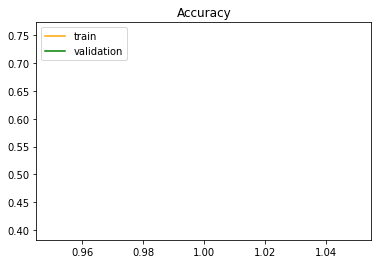

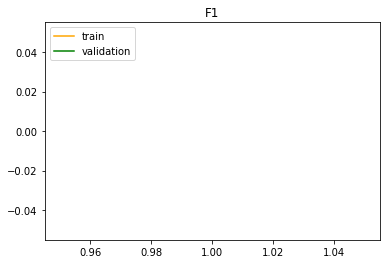

In [ ]:
train_acc = [ acc for acc, _ in train_curve ]
train_f1 = [ f1 for _, f1 in train_curve ]
valid_acc = [ acc for acc, _ in valid_curve ]
valid_f1 = [ f1 for _, f1 in valid_curve ]
epochs = [ i for i in range(1, len(valid_curve)+1) ]
import matplotlib.pyplot as plt
plt.title('Accuracy')
plt.plot(epochs, train_acc, label='train', color='orange')
plt.plot(epochs, valid_acc, label='validation', color='green')
plt.legend(loc='upper left')
plt.show()
plt.title('F1')
plt.plot(epochs, train_f1, label='train', color='orange')
plt.plot(epochs, valid_f1, label='validation', color='green')
plt.legend(loc='upper left')
plt.show()

### Test on randomly made up plot and review by myself
Now we will randomly input a movie plot summary and its review to see if the model decide the review is a spoiler or not.

In [ ]:
data.columns
print(left)
# data[data.movie_id=='tt0499549']
# data.head()

The movie begins in the year 1967 with a pregnant woman being admitted to a hospital, bleeding from the neck. Paramedics think she was attacked by some type of animal. Doctors perform an emergency C-Section, and her baby (a boy) is born alive just as she dies.Thirty years later a young man named Dennis (Kenny Johnson) is riding in a car with an attractive redhead named Racquel (Traci Lords) heading to an underground nightclub (located, oddly, in a slaughterhouse) somewhere in Los Angeles. After addressing the doorman in Russian, Racquel brings the young man into the club. The man is confused and trying to understand the rules of the club. Some of the regulars indifferently push him aside. Saying he needs a drink, the sprinkler suddenly system activates, raining blood down on everyone inside. It is then that he (and the audience) realizes that everyone in the club is a vampire.Dennis desperately tries to get away and winds up at the feet of a menacing figure in a black-leather trenchcoa

In [ ]:
# right = "When Thor's evil brother, Loki (Tom Hiddleston), gains access to the unlimited power of the energy cube called the Tesseract, Nick Fury (Samuel L. Jackson), director of S.H.I.E.L.D., initiates a superhero recruitment effort to defeat the unprecedented threat to Earth. Joining Fury's dream team are Iron Man (Robert Downey Jr.), Captain America (Chris Evans), the Hulk (Mark Ruffalo), Thor (Chris Hemsworth), the Black Widow (Scarlett Johansson) and Hawkeye (Jeremy Renner)."
# right =  'Tim killed Tom on a winter evening, and Sarah saw this scene.'
# left = 'Thor'#'Sarah saw Tom killed, it is Tim to blame'
left = str(data[data.movie_id=='tt0120611'].sentence1[0:1].values[0])
# right = "Circa 2154. The US army lands up in Pandora, an earth-sized moon in outer space. Their objective: to extract the much-needed minerals from Pandora's soil. But before they can do that, they must fight the peace-loving indigenous inhabitants of the alien world, relocate or destroy them with their spies and bombs."
# right = "Great movie. It lives up to its hype and does not disappoint. I would recommend watching the extended version if you haven't already to this point. It explains the story and plot more better and doesn't leave you confused and pondering on trying to figure out the plot and what could've actually happened that didn't made sense. Because when I saw the theatrical release, I knew it didn't feel complete and there was some plot holes that didn't really fill in certain segments of the movie. The CGI "
# right = str(data[data.movie_id=='tt0499549'].sentence1[0:1].values[0])
right = left#"Neytiri (Zoe Saldana) kills Quaritch and she helps Jake (Sam Worthington) just as he's on the brink of dying after he gets knocked out of the pod where he's linked to his Na'vi body. The military forces go back to Earth and a few trustworthy humans, such as Jake and Norm, stay on Pandora. A ritual at the Tree of Souls is performed and Jake's mind is transferred permanently to his Na'vi body."

left_token = indexer.vocab[tokenizer.tokenizer(left)]
right_token = indexer.vocab[tokenizer.tokenizer(right)]

In [ ]:
# mz.
# model.collect_params().initialize(force_reinit=True, ctx=mx.gpu())
left_input = nd.array(left_token, ctx=ctx).reshape(1,-1)
right_input = nd.array(right_token, ctx=ctx).reshape(1,-1)

pred, att = model(left_input, right_input)
pred, nd.argmax(pred, axis=1).asscalar()

(
 [[ 0.358205   -0.35204744]]
 <NDArray 1x2 @gpu(0)>, 0.0)

In [ ]:
!ls